# Classifying Fashion MNIST with spiking activations

In this example we assume that you are already familiar with building and training
standard, non-spiking neural networks in PyTorch. We would recommend checking out the
[PyTorch
documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)
if you would like a more basic introduction to how PyTorch works. In this example we
will walk through how we can convert a non-spiking model into a spiking model using
PyTorchSpiking, and various techniques that can be used to fine tune performance.

In [ ]:
!pip install pytorch-spiking

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pylint: disable=redefined-outer-name

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

import pytorch_spiking

torch.manual_seed(0)
np.random.seed(0)

## Loading data

We'll begin by loading the Fashion MNIST data:

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



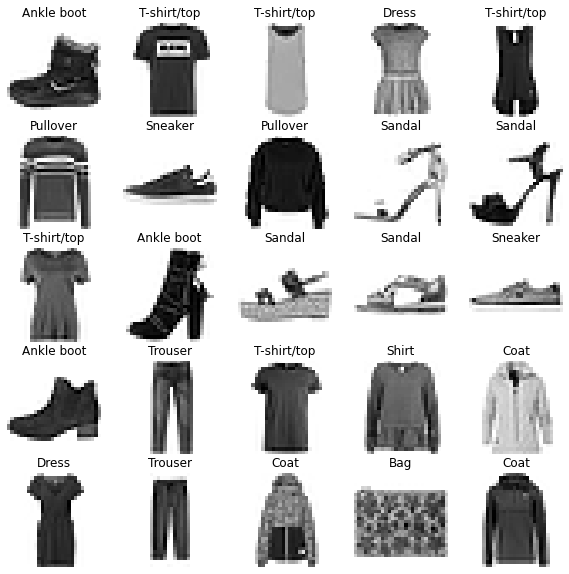

In [ ]:
train_images, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
test_images, test_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=False, download=True)
)
test_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
test_labels = np.asarray(train_labels, dtype=np.int64)

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

## Non-spiking model

Next we'll build and train a simple non-spiking model to classify the Fashion MNIST
images.

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)


def train(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.Adam(input_model.parameters())

    input_model.train()
    for j in range(10):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_model.zero_grad()

            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_model(torch.tensor(batch_in))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()

            loss.backward()
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print("Train accuracy (%d): " % j, train_acc.numpy())

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1

    print("Test accuracy:", test_acc.numpy())


train(model, train_images, test_images)

Train accuracy (0):  0.81921667
Train accuracy (1):  0.86256665
Train accuracy (2):  0.8755
Train accuracy (3):  0.88441664
Train accuracy (4):  0.88956666
Train accuracy (5):  0.89615
Train accuracy (6):  0.9005167
Train accuracy (7):  0.9040667
Train accuracy (8):  0.9086
Train accuracy (9):  0.9127167
Test accuracy: 0.91005


## Spiking model

Next we will create an equivalent spiking model. There are three important changes here:

1. Add a temporal dimension to the data/model.

Spiking models always run over time (i.e., each forward pass through the model will run
for some number of timesteps). This means that we need to add a temporal dimension to
the data, so instead of having shape `(batch_size, ...)` it will have shape
`(batch_size, n_steps, ...)`. For those familiar with working with RNNs, the principles
are the same; a spiking neuron accepts temporal data and computes over time, just like
an RNN.

2. Replace any activation functions with `pytorch_spiking.SpikingActivation`.

`pytorch_spiking.SpikingActivation` can encapsulate any activation function, and will
produce an equivalent spiking implementation. Neurons will spike at a rate proportional
to the output of the base activation function. For example, if the activation function
is outputting a value of 10, then the wrapped `SpikingActivation` will output spikes at
a rate of 10Hz (i.e., 10 spikes per 1 simulated second, where 1 simulated second is
equivalent to some number of timesteps, determined by the `dt` parameter of
`SpikingActivation`).

3. Pool across time

The output of our `pytorch_spiking.SpikingActivation` layer is also a timeseries. For
classification, we need to aggregate that temporal information somehow to generate a
final prediction. Averaging the output over time is usually a good approach (but not the
only method; we could also, e.g., look at the output on the last timestep or the time to
first spike). We add a `pytorch_spiking.TemporalAvgPool` layer to average across the
temporal dimension of the data.

In [ ]:
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

In [ ]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model, train_sequences, test_sequences)

Train accuracy (0):  0.81923336
Train accuracy (1):  0.8624833
Train accuracy (2):  0.87495
Train accuracy (3):  0.8829167
Train accuracy (4):  0.8895
Train accuracy (5):  0.894
Train accuracy (6):  0.8994167
Train accuracy (7):  0.9037167
Train accuracy (8):  0.9078
Train accuracy (9):  0.9113
Test accuracy: 0.17701666


We can see that while the training accuracy is as good as we expect, the test accuracy
is not. This is due to a unique feature of `SpikingActivation`; it will automatically
swap the behaviour of the spiking neurons during training. Because spiking neurons are
(in general) not differentiable, we cannot directly use the spiking activation function
during training. Instead, SpikingActivation will use the base (non-spiking) activation
during training, and the spiking version during inference. So during training above we
are seeing the performance of the non-spiking model, but during evaluation we are seeing
the performance of the spiking model.

So the question is, why is the performance of the spiking model so much worse than the
non-spiking equivalent, and what can we do to fix that?

## Simulation time

Let's visualize the output of the spiking model, to get a better sense of what is going
on.

In [ ]:
def check_output(seq_model, modify_dt=None):  # noqa: C901
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model in a form that will let us access the output of
    # intermediate layers
    class Model(torch.nn.Module):
        def __init__(self):
            super().__init__()

            self.has_temporal_pooling = False
            for i, module in enumerate(seq_model.modules()):
                if isinstance(module, pytorch_spiking.TemporalAvgPool):
                    # remove the pooling so that we can see the model's output over time
                    self.has_temporal_pooling = True
                    continue

                if isinstance(
                    module, (pytorch_spiking.SpikingActivation, pytorch_spiking.Lowpass)
                ):
                    # update dt, if specified
                    if modify_dt is not None:
                        module.dt = modify_dt
                    # always return the full time series so we can visualize it
                    module.return_sequences = True

                if isinstance(module, pytorch_spiking.SpikingActivation):
                    # save this layer so we can access it later
                    self.spike_layer = module

                if i > 0:
                    self.add_module(str(i), module)

        def forward(self, inputs):
            x = inputs

            for i, module in enumerate(self.modules()):
                if i > 0:
                    x = module(x)

                    if isinstance(module, pytorch_spiking.SpikingActivation):
                        # save this layer so we can access it later
                        spike_output = x

            return x, spike_output

    func_model = Model()

    # run model
    func_model.eval()
    with torch.no_grad():
        output, spikes = func_model(
            torch.tensor(
                test_sequences.reshape(
                    test_sequences.shape[0], test_sequences.shape[1], -1
                )
            )
        )
    output = output.numpy()
    spikes = spikes.numpy()

    if func_model.has_temporal_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * func_model.spike_layer.dt
    n_spikes = spikes * func_model.spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * func_model.spike_layer.dt,
            torch.softmax(torch.tensor(output[ii]), dim=-1),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Test accuracy: 17.86%
Spike rate per neuron (Hz): min=0.00 mean=0.62 max=100.00


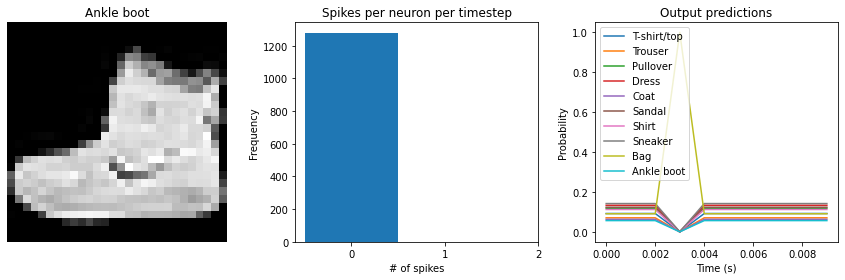

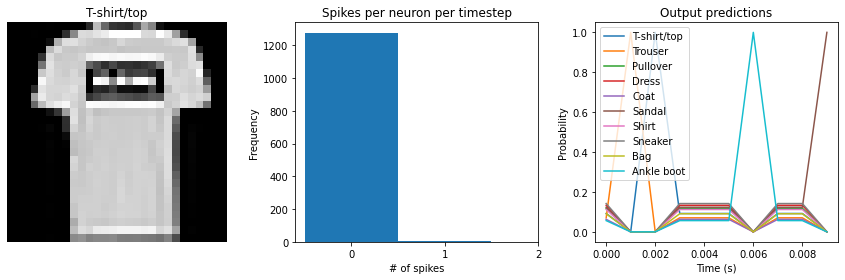

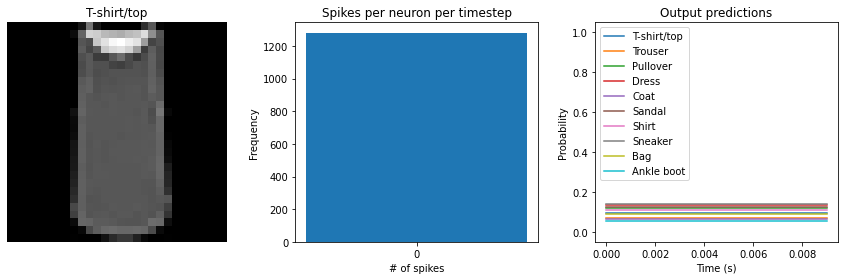

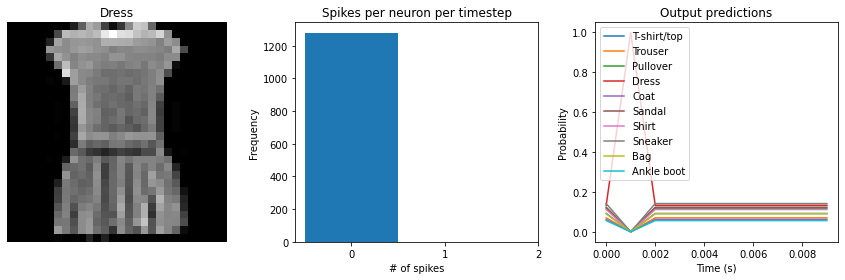

In [ ]:
check_output(spiking_model)

We can see an immediate problem: the neurons are hardly spiking at all. The mean number
of spikes we're getting out of each neuron in our SpikingActivation layer is very close
to zero, and as a result the output is mostly flat.

To help understand why, we need to think more about the temporal nature of spiking
neurons. Recall that the layer is set up such that if the base activation function were
to be outputting a value of 1, the spiking equivalent would be spiking at 1Hz (i.e.,
emitting one spike per second). In the above example we are simulating for 10 timesteps,
with the default `dt` of 0.001s, so we're simulating a total of 0.01s. If our neurons
aren't spiking very rapidly, and we're only simulating for 0.01s, then it's not
surprising that we aren't getting any spikes in that time window.

We can increase the value of `dt`, effectively running the spiking neurons for longer,
in order to get a more accurate measure of the neuron's output. Basically this allows us
to collect more spikes from each neuron, giving us a better estimate of the neuron's
actual spike rate. We can see how the number of spikes and accuracy change as we
increase `dt`:

Test accuracy: 64.54%
Spike rate per neuron (Hz): min=0.00 mean=0.61 max=30.00


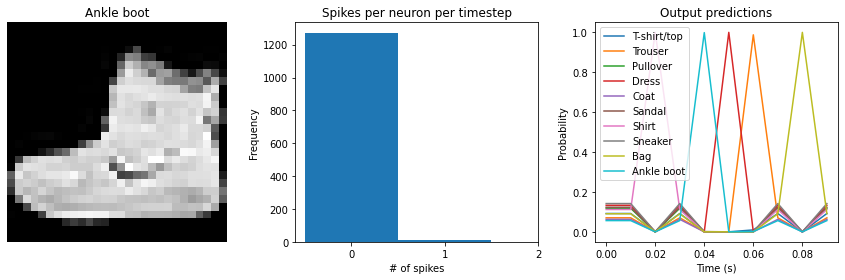

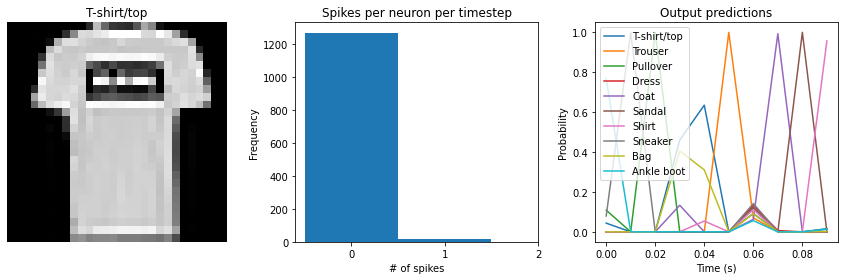

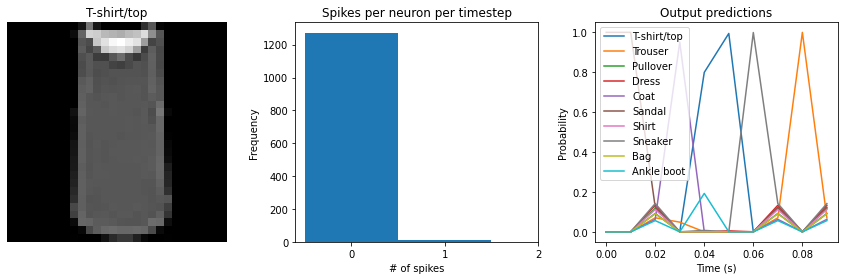

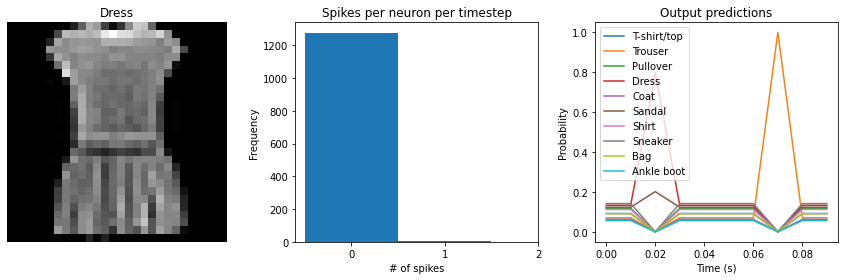

In [ ]:
# dt=0.01 * 10 timesteps is equivalent to 0.1s of simulated time
check_output(spiking_model, modify_dt=0.01)

Test accuracy: 90.42%
Spike rate per neuron (Hz): min=0.00 mean=0.61 max=23.00


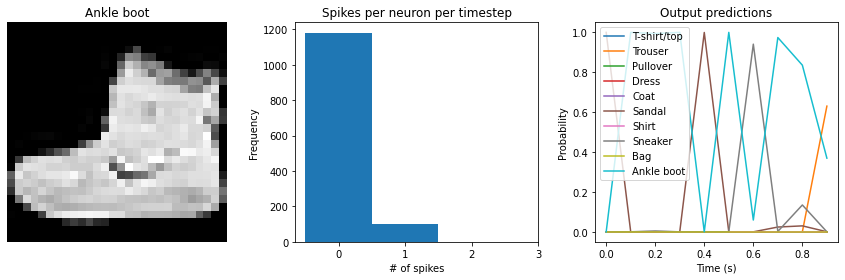

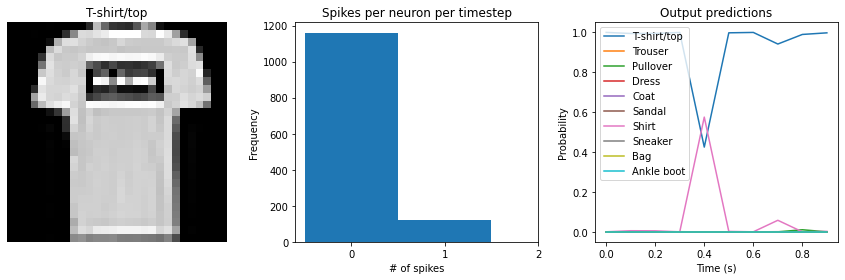

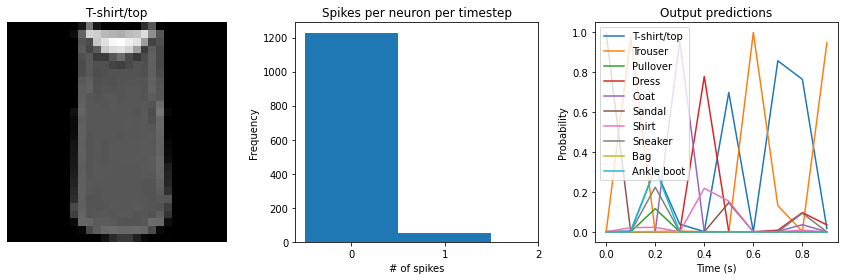

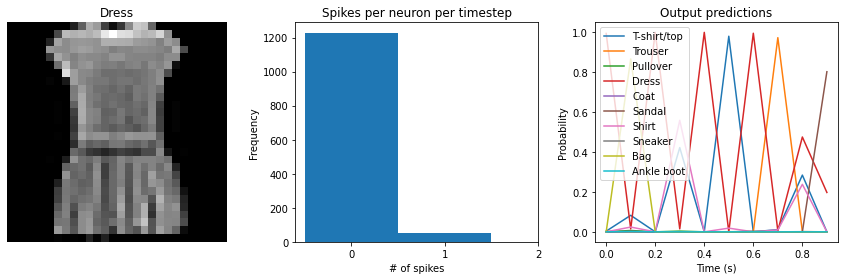

In [ ]:
check_output(spiking_model, modify_dt=0.1)

Test accuracy: 90.88%
Spike rate per neuron (Hz): min=0.00 mean=0.61 max=23.40


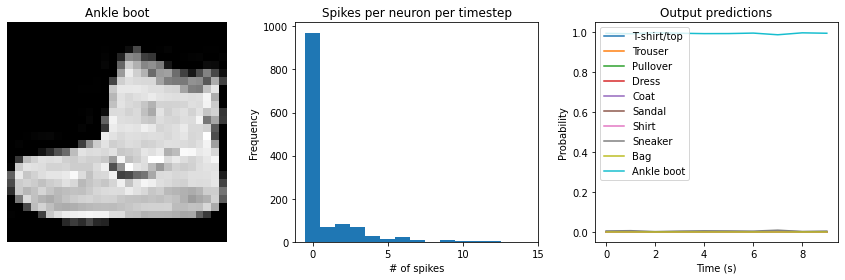

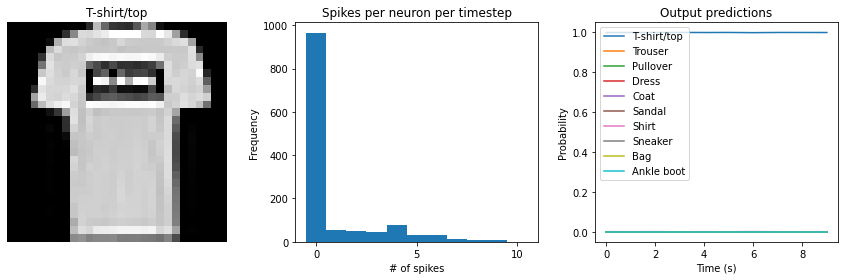

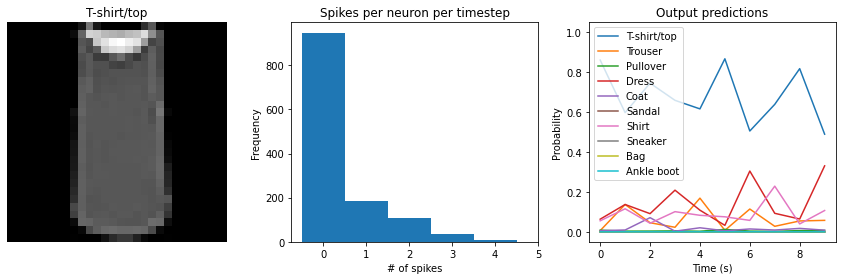

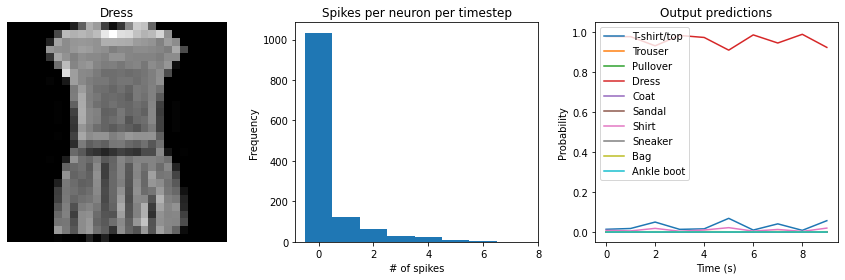

In [ ]:
check_output(spiking_model, modify_dt=1)

We can see that as we increase `dt` the performance of the spiking model increasingly
approaches the non-spiking performance. In addition, as `dt` increases, the number of
spikes is increasing. To understand why this improves accuracy, keep in mind that
although the simulated time is increasing, the actual number of timesteps is still 10 in
all cases. We're effectively binning all the spikes that occur on each time step. So as
our bin sizes get larger (increasing `dt`), the spike counts will more closely
approximate the "true" output of the underlying non-spiking activation function.

One might be tempted to simply increase `dt` to a very large value, and thereby always
get great performance. But keep in mind that when we do that we have likely lost any of
the advantages that were motivating us to investigate spiking models in the first place.
For example, one prominent advantage of spiking models is temporal sparsity (we only
need to communicate occasional spikes, rather than continuous values). However, with
large `dt` the neurons are likely spiking every simulation time step (or multiple times
per timestep), so the activity is no longer temporally sparse.

Thus setting `dt` represents a trade-off between accuracy and temporal sparsity.
Choosing the appropriate value will depend on the demands of your application.

## Spiking aware training

As mentioned above, by default SpikingActivation layers will use the non-spiking
activation function during training and the spiking version during inference. However,
similar to the idea of
[quantization aware
training](https://www.tensorflow.org/model_optimization/guide/quantization/training),
often we can improve performance by partially incorporating spiking behaviour during
training. Specifically, we will use the spiking activation on the forward pass, while
still using the non-spiking version on the backwards pass. This allows the model to
learn weights that account for the discrete, temporal nature of the spiking activities.

In [ ]:
spikeaware_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

train(spikeaware_model, train_sequences, test_sequences)

Train accuracy (0):  0.6974
Train accuracy (1):  0.7866
Train accuracy (2):  0.80738336
Train accuracy (3):  0.81915
Train accuracy (4):  0.8278667
Train accuracy (5):  0.8349
Train accuracy (6):  0.84
Train accuracy (7):  0.84353334
Train accuracy (8):  0.84686667
Train accuracy (9):  0.8488167
Test accuracy: 0.8533667


Test accuracy: 85.42%
Spike rate per neuron (Hz): min=0.00 mean=2.69 max=70.00


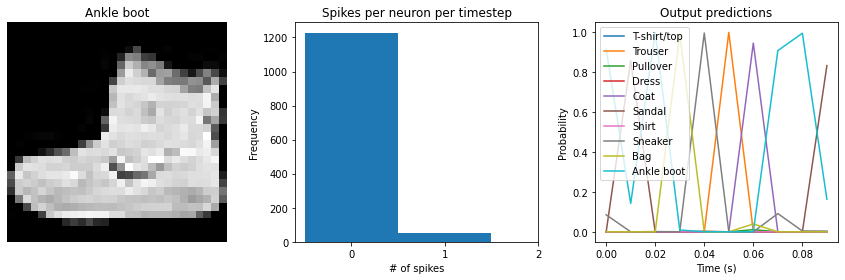

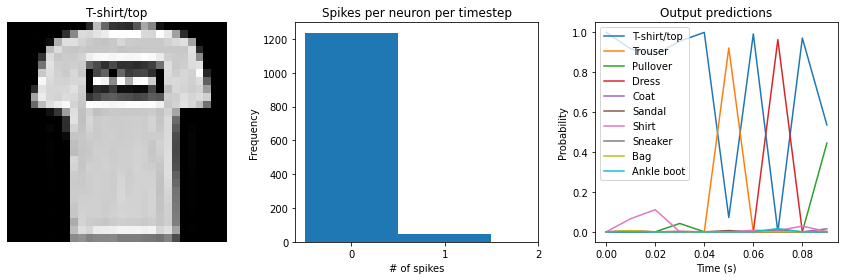

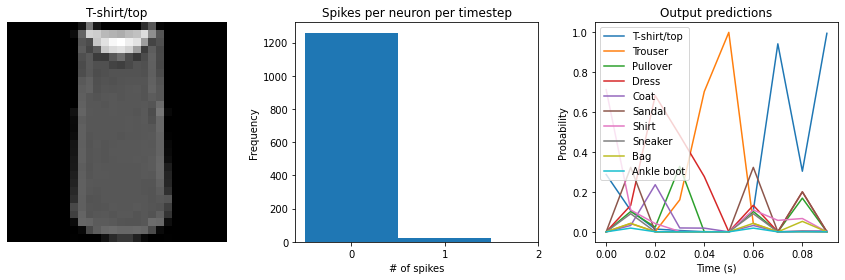

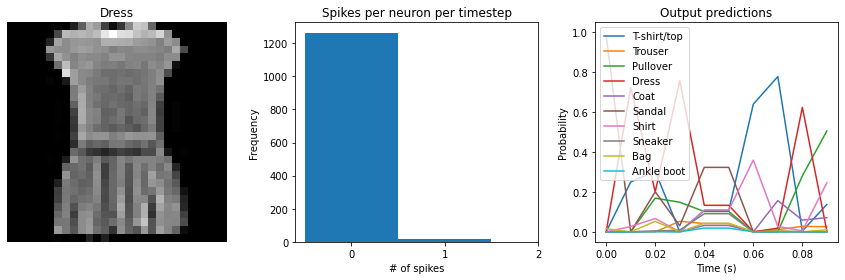

In [ ]:
check_output(spikeaware_model)

We can see that with `spiking_aware_training` we're getting better performance than we
were with the equivalent `dt` value above. The model has learned weights that are less
sensitive to the discrete, sparse output produced by the spiking neurons.

## Spike rate regularization

As we saw in the [Simulation time section](#Simulation-time), the spiking rate of the
neurons is very important. If a neuron is spiking too slowly then we don't have enough
information to determine its output value. Conversely, if a neuron is spiking too
quickly then we may lose the spiking advantages we are looking for, such as temporal
sparsity.

Thus it can be helpful to more directly control the firing rates in the model by
applying regularization penalties during training. For example, we could add an L2
penalty to the output of the spiking activation layer.

In [ ]:
# construct model using a generic Module so that we can
# access the spiking activations in our loss function
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.dense0 = torch.nn.Linear(784, 128)
        self.spiking_activation = pytorch_spiking.SpikingActivation(
            torch.nn.ReLU(), dt=0.01, spiking_aware_training=True
        )
        self.temporal_pooling = pytorch_spiking.TemporalAvgPool()
        self.dense1 = torch.nn.Linear(128, 10)

    def forward(self, inputs):
        x = self.dense0(inputs)
        spikes = self.spiking_activation(x)
        spike_rates = self.temporal_pooling(spikes)
        output = self.dense1(spike_rates)

        return output, spike_rates


regularized_model = Model()

minibatch_size = 32
optimizer = torch.optim.Adam(regularized_model.parameters())

regularized_model.train()
for j in range(10):
    train_acc = 0
    for i in range(train_sequences.shape[0] // minibatch_size):
        regularized_model.zero_grad()

        batch_in = train_sequences[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + train_sequences.shape[1:-2] + (784,))
        batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output, spike_rates = regularized_model(torch.tensor(batch_in))

        # compute sparse categorical cross entropy loss
        logp = torch.nn.functional.log_softmax(output, dim=-1)
        logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
        loss = -logpy.mean()

        # add activity regularization
        reg_weight = 1e-3  # weight on regularization penalty
        target_rate = 20  # target spike rate (in Hz)
        loss += reg_weight * torch.mean(
            torch.sum((spike_rates - target_rate) ** 2, dim=-1)
        )

        loss.backward()
        optimizer.step()

        train_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    train_acc /= i + 1
    print("Train accuracy (%d): " % j, train_acc.numpy())

Train accuracy (0):  0.5893667
Train accuracy (1):  0.6879333
Train accuracy (2):  0.70278335
Train accuracy (3):  0.7115167
Train accuracy (4):  0.71206665
Train accuracy (5):  0.7172
Train accuracy (6):  0.71826667
Train accuracy (7):  0.71955
Train accuracy (8):  0.7205833
Train accuracy (9):  0.72291666


Test accuracy: 70.49%
Spike rate per neuron (Hz): min=0.00 mean=18.97 max=40.00


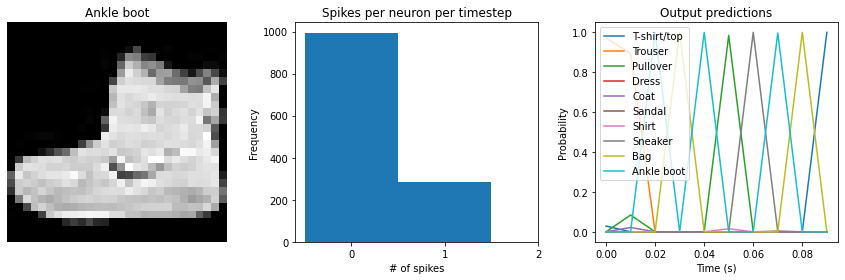

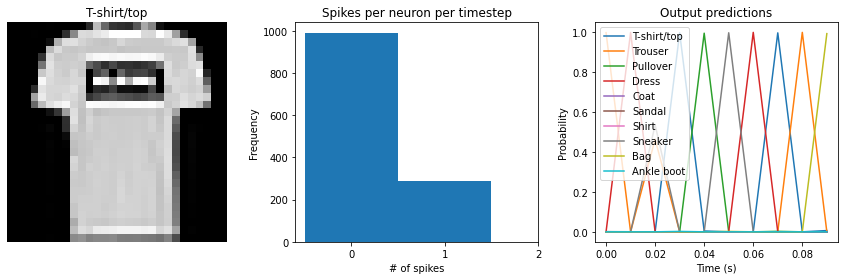

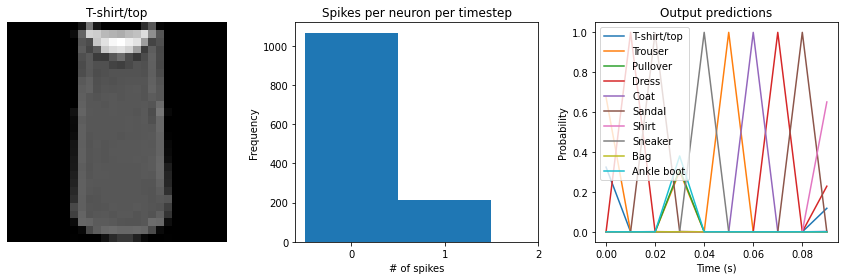

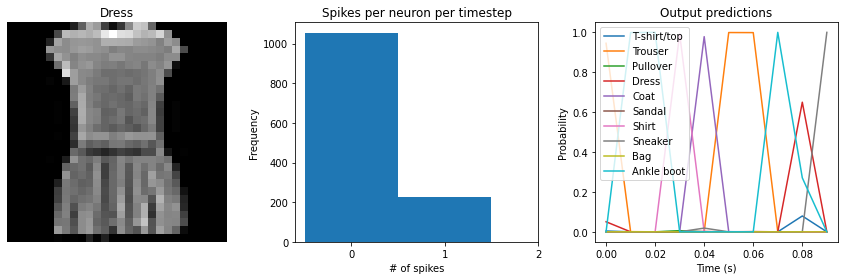

In [ ]:
check_output(regularized_model)

We can see that the spike rates have moved towards the 20 Hz target we specified.
However, the test accuracy has dropped, since we're adding an additional optimization
constraint. (The accuracy is still higher than the original result with `dt=0.01`, due
to the higher spike rates.) We could lower the regularization weight to allow more
freedom in the firing rates. Again, this is a tradeoff that is made between controlling
the firing rates and optimizing accuracy, and the best value for that tradeoff will
depend on the particular application (e.g., how important is it that spike rates fall
within a particular range?).

## Lowpass filtering

Another tool we can employ when working with SpikingActivation layers is filtering. As
we've seen, the output of a spiking layer consists of discrete, temporally sparse spike
events. This makes it difficult to determine the spike rate of a neuron when just
looking at a single timestep. In the cases above we have worked around this by using a
`TemporalAveragePooling` layer to average the output across all timesteps before
classification.

Another way to achieve this is to compute some kind of moving average of the spiking
output across timesteps. This is effectively what filtering is doing. PyTorchSpiking
contains a Lowpass layer, which implements a
[lowpass filter](https://en.wikipedia.org/wiki/Low-pass_filter). This has a parameter
`tau`, known as the filter time constant, which controls the degree of smoothing the
layer will apply. Larger `tau` values will apply more smoothing, meaning that we're
aggregating information across longer periods of time, but the output will also be
slower to adapt to changes in the input.

By default the `tau` values are trainable. We can use this in combination with spiking
aware training to enable the model to learn time constants that best trade off spike
noise versus response speed.

Unlike `pytorch_spiking.TemporalAvgPool`, `pytorch_spiking.Lowpass` computes outputs for
all timesteps by default. This makes it possible to apply filtering throughout the
model—not only on the final layer—in the case that there are multiple spiking layers.
For the final layer, we can pass `return_sequences=False` to have the layer only return
the output of the final timestep, rather than the outputs of all timesteps.

In [ ]:
dt = 0.01

filtered_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), spiking_aware_training=True, dt=dt
    ),
    # add a lowpass filter on output of spiking layer
    # note: the lowpass dt doesn't necessarily need to be the same as the
    # SpikingActivation dt, but it's probably a good idea to keep them in sync
    # so that if we change dt the relative effect of the lowpass filter is unchanged
    pytorch_spiking.Lowpass(units=128, tau=0.1, dt=dt, return_sequences=False),
    torch.nn.Linear(128, 10),
)

train(filtered_model, train_sequences, test_sequences)

Train accuracy (0):  0.7161833
Train accuracy (1):  0.7952
Train accuracy (2):  0.8158
Train accuracy (3):  0.82671666
Train accuracy (4):  0.83353335
Train accuracy (5):  0.8413
Train accuracy (6):  0.84751666
Train accuracy (7):  0.85171664
Train accuracy (8):  0.85466665
Train accuracy (9):  0.8570167
Test accuracy: 0.86158335


Test accuracy: 86.07%
Spike rate per neuron (Hz): min=0.00 mean=4.31 max=70.00


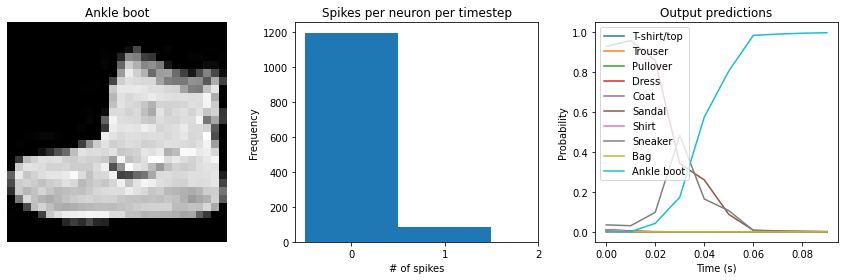

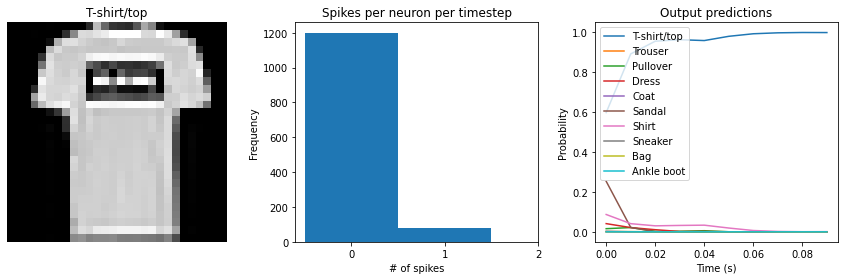

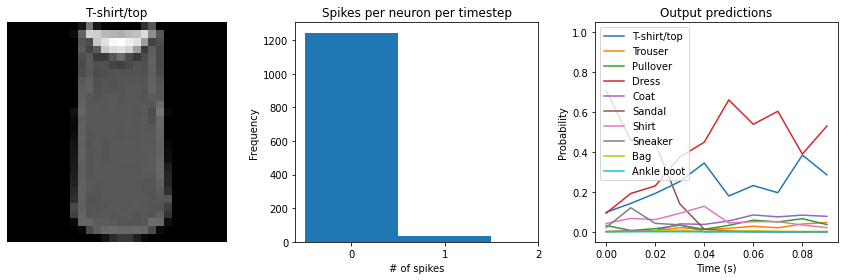

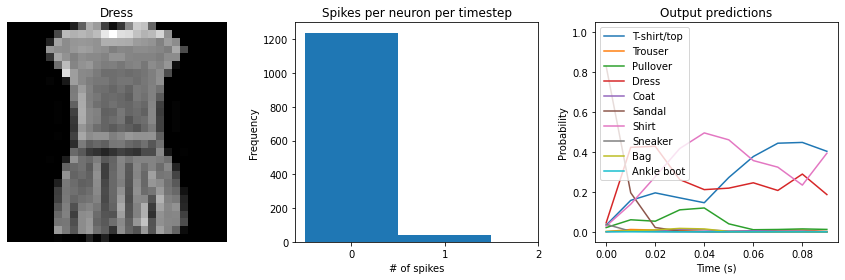

In [ ]:
check_output(filtered_model)

We can see that the model performs similarly to the previous
[spiking aware training](#Spiking-aware-training) example, which makes sense since, for
a static input image, a moving average is very similar to a global average. We would
need a more complicated model, with multiple spiking layers or inputs that are changing
over time, to really see the benefits of a Lowpass layer.

## Summary

We can use `SpikingActivation` layers to convert any activation function to an
equivalent spiking implementation. Models with SpikingActivations can be trained and
evaluated in the same way as non-spiking models, thanks to the swappable
training/inference behaviour.

There are also a number of additional features that should be kept in mind in order to
optimize the performance of a spiking model:

- [Simulation time](#Simulation-time): by adjusting `dt` we can trade off temporal
  sparsity versus accuracy
- [Spiking aware training](#Spiking-aware-training): incorporating spiking dynamics on
  the forward pass can allow the model to learn weights that are more robust to spiking
  activations
- [Spike rate regularization](#Spike-rate-regularization): we can gain more control over
  spike rates by directly incorporating activity regularization into the optimization
  process
- [Lowpass filtering](#Lowpass-filtering): we can achieve better accuracy with fewer
  spikes by aggregating spike data over time